In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from stacked_mnist import StackedMNISTData, DataMode
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from auto_encoder import AutoEncoder
import tensorflow_probability as tfp
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

In [4]:
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [190]:
padding='same'
encoded_shape = 8

In [191]:
prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(encoded_shape), scale=1.), 
                                reinterpreted_batch_ndims=1)

In [193]:
encoder_input = keras.Input(shape=(28, 28, 1), name="image_input")
x = layers.Conv2D(32, 5, strides=1, padding=padding, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, strides=2, padding=padding, activation="relu")(x)
# x = layers.Conv2D(64, 5, strides=1, padding=padding, activation="relu")(x)
x = layers.Conv2D(64, 3, strides=2, padding=padding, activation="relu")(x)
# x = layers.Conv2D(128, 7, strides=1, padding=padding, activation="relu")(x)

x = layers.Flatten()(x)


x = layers.Dense(tfp.layers.IndependentNormal.params_size(encoded_shape), activation=None)(x)
# sigma = layers.Dense(2)(x)

# def sampling(args):
#     z_mean, z_sigma = args
#     epsilon = keras.backend.random_normal(shape=(tf.shape(z_mean)[0], 2),
#                               mean=0., stddev=1)
#     return z_mean + (z_sigma) * epsilon

# z = layers.Lambda(sampling)([mu, sigma])
encoder_output = tfp.layers.IndependentNormal(
    encoded_shape,
    activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=2))(x)


# encoder = keras.Model(encoder_input, [mu, sigma, z], name="encoder")
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 conv2d_35 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 flatten_14 (Flatten)        (None, 3136)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                50192     
                                                                 
 independent_normal_6 (Indep  ((None, 8),              0   

In [194]:
decoder_input = keras.Input(shape=(encoded_shape,), name='decoder_input')
x = layers.Reshape((1,1,encoded_shape))(decoder_input)
x = layers.Conv2DTranspose(64, 7, strides=1,padding='valid', activation="relu")(x)
x = layers.Conv2DTranspose(64, 5, strides=2,padding='same', activation="relu")(x)
x = layers.Conv2DTranspose(32,5,strides=2,padding='same', activation='relu')(x)

x = layers.Conv2DTranspose(1,5,strides=1,padding='same', activation=None)(x)
x = layers.Flatten()(x)

decoder_output = tfp.layers.IndependentBernoulli((28,28,1), tfp.distributions.Bernoulli.logits)(x)

# decoder_output = layers.Conv2DTranspose(1,3,strides=(1,1),padding='same', activation='sigmoid')(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 reshape_7 (Reshape)         (None, 1, 1, 8)           0         
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 7, 7, 64)         25152     
 Transpose)                                                      
                                                                 
 conv2d_transpose_35 (Conv2D  (None, 14, 14, 64)       102464    
 Transpose)                                                      
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 28, 28, 32)       51232     
 Transpose)                                                      
                                                           

In [195]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

In [196]:
autoencoder_input = keras.Input(shape=(28, 28, 1), name="ae_image_input")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

# reconstruction_loss = keras.losses.binary_crossentropy(encoder_input, decoded_img)
# kl_loss = 1 + keras.backend.log(sigma) - keras.backend.square(mu) - sigma
# kl_loss = keras.backend.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)

autoencoder = keras.Model(
    autoencoder_input, decoded_img, name="autoencoder")
# autoencoder.add_loss(vae_loss)
autoencoder.compile(
            optimizer='adam', loss=negloglik,  metrics=['accuracy'])
            # optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [197]:
autoencoder.fit(x=x_train, y=x_train, shuffle=True, batch_size=512, epochs=25,
                                 validation_data=(x_test, x_test))

Epoch 1/25
118/118 [==============================] - 7s 39ms/step - loss: 258.5681 - accuracy: 0.8677 - val_loss: 206.3292 - val_accuracy: 0.8658
Epoch 2/25
118/118 [==============================] - 4s 34ms/step - loss: 179.7260 - accuracy: 0.8876 - val_loss: 157.7012 - val_accuracy: 0.9199
Epoch 3/25
118/118 [==============================] - 4s 34ms/step - loss: 152.4631 - accuracy: 0.9265 - val_loss: 147.4224 - val_accuracy: 0.9303
Epoch 4/25
118/118 [==============================] - 4s 35ms/step - loss: 146.6363 - accuracy: 0.9326 - val_loss: 144.0893 - val_accuracy: 0.9365
Epoch 5/25
118/118 [==============================] - 4s 34ms/step - loss: 144.0169 - accuracy: 0.9352 - val_loss: 142.6095 - val_accuracy: 0.9389
Epoch 6/25
118/118 [==============================] - 4s 34ms/step - loss: 142.1789 - accuracy: 0.9370 - val_loss: 140.6882 - val_accuracy: 0.9395
Epoch 7/25
118/118 [==============================] - 4s 34ms/step - loss: 140.9740 - accuracy: 0.9383 - val_loss: 139

In [198]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

result = autoencoder(img).sample()
# result = autoencoder.predict(img)



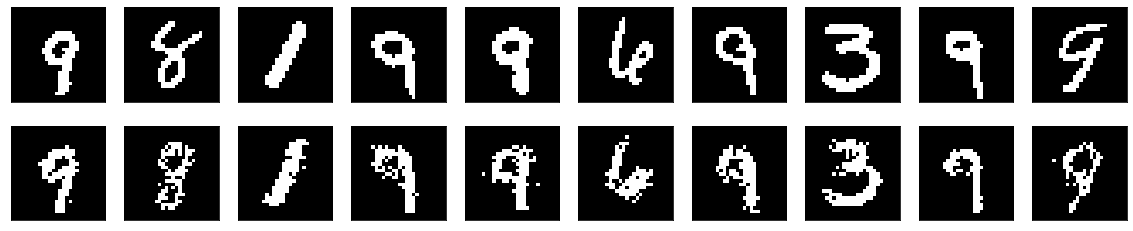

In [199]:
AutoEncoder.plot_n_images(10, img[20:], result[20:])

In [196]:
encoder.predict(img[0:3])

array([[-0.34610024, -0.6192415 ],
       [-1.0268775 ,  0.35393915],
       [ 0.7614886 , -0.09611729]], dtype=float32)

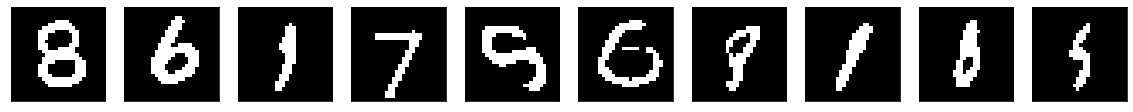

In [208]:
plt.figure(figsize=(20, 4))
z = np.random.randn(11,encoded_shape)
d = decoder(z).mode()
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(d[i])

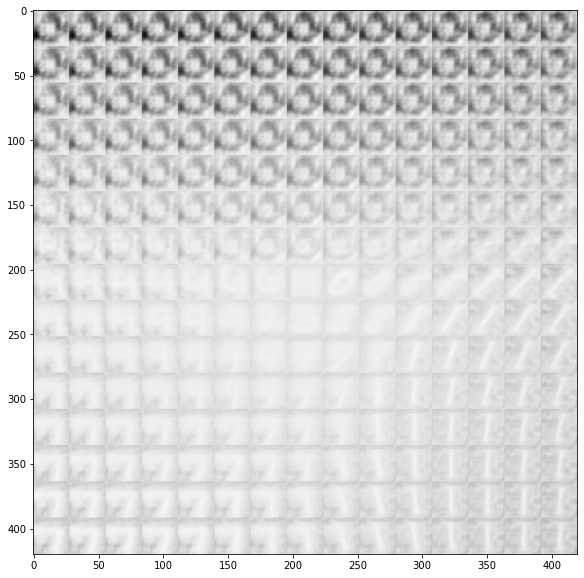

In [133]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)#.mean()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [153]:

net = VerificationNet(force_learn=False)
net.train(generator=gen, epochs=100)

# I have no data generator (VAE or whatever) here, so just use a sampled set
img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = net.check_class_coverage(data=img, tolerance=.98)
pred, acc = net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 98.51%
Accuracy: 98.39%


In [219]:

img, labels = gen.get_random_batch(training=False,  batch_size=10000)

# result = autoencoder.autoencode(img)
result = autoencoder(img).mode()
cov = net.check_class_coverage(data=result, tolerance=.90)
pred, acc = net.check_predictability(data=result, correct_labels=labels, tolerance=0.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 94.83%
Accuracy: 84.29%


In [219]:
from vae import VariationalAutoEncoder

vae = VariationalAutoEncoder(force_learn=True)

Not trained


In [220]:
vae.train(x_train=x_train, x_test=x_test, epochs=20)

Not trained
Epoch 1/20
Cause: could not parse the source code of <function VariationalAutoEncoder.__init__.<locals>.<lambda> at 0x000001F657244700>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function VariationalAutoEncoder.__init__.<locals>.<lambda> at 0x000001F657244700>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/118 [==============================] - 15s 73ms/step - loss: 244.9140 - accuracy: 0.8677 - val_loss: 208.1867 - val_accuracy: 0.8658
Epoch 2/20
118/118 [==============================] - 7s 62ms/step - loss: 207.5966 - accuracy: 0.8677 - val_loss: 207.1025 - val_accuracy: 0.8658
Epoch 3/20
118/118 [==============================] - 7s 63ms/step - loss: 207.0139 - accuracy: 0.8677 - val_loss: 207.0127 - val_accuracy: 0.8658
Epoch 4/20
118/118 [====

True

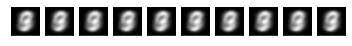

In [221]:
d = vae.generate_images(11)
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(d[i])